## Flight Data Cleaning
The original flight data is retrieved from the Heathrow Airport website using a Selenium webscraper.

In [ ]:
# set up
import pandas as pd
import numpy as np

# additional data source
import osmnx as ox
import geopandas as gpd
import requests
from geopy import Nominatim
from shapely.geometry import Point

# visualistion
import matplotlib.pyplot as plt 

In [2]:
# load the dataframe 
df = pd.read_csv("../data/23APR2024_LHR.csv")
df.head()

,code,time_sch,orig,status,url,time_act,iata,dest
0,TP1363,06:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,06:21,Arrive Lisbon (LIS),Lisbon
1,OS458,06:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,06:12,Arrive Vienna (VIE),Vienna
2,LX345,06:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,06:14,Arrive Zurich (ZRH),Zurich
3,BA472,06:10,London,DEPARTED,https://www.heathrow.com/departures/terminal-5...,06:24,Arrive Barcelona (BCN),Barcelona
4,AF1381,06:15,London,DEPARTED,https://www.heathrow.com/departures/terminal-4...,06:42,Arrive Paris (CDG),Paris


## Data Pre-Processing
For working the point of view of the Heathrow Airport, we will pre-process the data with the following columns:
* Airline Code Varchar(2)
* Departure (bool)
* Simulate passenger number
* org/des (str)
* Time delayed
* Terminal number


In [5]:
# get airline code
df['airline'] =df['code'].apply(lambda code: code[0:2])
# departure boolean
df['dept'] = df['dest'] != "London"
# dest/orig
df.loc[df['dept'],"dest/orig"] = df.loc[df['dept'],"dest"]
df.loc[~df['dept'],"dest/orig"] = df.loc[~df['dept'],"orig"]
# simulate passsenger load
# pass_no = np.random.normal(loc = 200, scale = 75, size = len(df))
# pass_no = np.floor(pass_no)
# df["pass_no"] = pass_no
# get the dest/orig ICAO code
df["iata_airport"] = df['iata'].str.extract(r"([A-Z]{3})")
# get the icao dest/orig
df["iata_city"] = df['iata'].apply(lambda string: string[7:-6])
# terminal
df['terminal'] = df["url"].str.extract(r"terminal-(.)")

Because there is a curfew at Heathrow Airport, flights are almost always scheduled with enough buffer away from the midnight timestamp. However, this might not be true for the actual time the flight arrived/departed. We will first fill in the null data for the date of actual time and validate the date by considering the temporal sequence of the scheduled time and the actual time.

To compute the time delayed, I follow the steps:
1. Impute the date of the flight
2. Compute difference `time_diff `between scheduled and actual time
3. Validate the actual date of the flight
4. Update invalid actual date
5. Compute element-wise `max(0, time_diff)` to ignore time delayed for "on schedule" flight
6. Fill in NA value for time dealyed

In [79]:
# date string
date = "2024-04-23 "
# impute the date time column
df['time_sch'] = date + df['time_sch']
df['time_sch'] = pd.to_datetime(df['time_sch'], format = "%Y-%m-%d %H:%M")

# impute date from time actual
df['time_act'] = date + df['time_act']
df['time_act'] = pd.to_datetime(df['time_act'], format = "%Y-%m-%d %H:%M")

# compare the hour 
df['time_diff'] = (df['time_act']-df['time_sch']).dt.total_seconds() / 60

(array([ 1.,  6.,  3., 14., 11., 30., 33., 23., 14.,  3.]),
 array([-55. , -49.7, -44.4, -39.1, -33.8, -28.5, -23.2, -17.9, -12.6,
         -7.3,  -2. ]),
 <BarContainer object of 10 artists>)

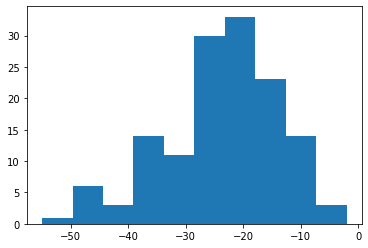

In [80]:
plt.hist(df.loc[df['time_sch'].dt.hour > df['time_act'].dt.hour,"time_diff"])

From this plot, it doen't seem to be any flights that has been delayed to the day after.

In [81]:
# # dealyed roll forward
# f_roll_indice = (df["time_diff"] < -60)
# # update the date
# df.loc[f_roll_indice,"time_act"] = df.loc[f_roll_indice,"time_act"] + pd.Timedelta(days = 1)

(array([ 1.,  6.,  3., 14., 11., 30., 33., 23., 14.,  3.]),
 array([-55. , -49.7, -44.4, -39.1, -33.8, -28.5, -23.2, -17.9, -12.6,
         -7.3,  -2. ]),
 <BarContainer object of 10 artists>)

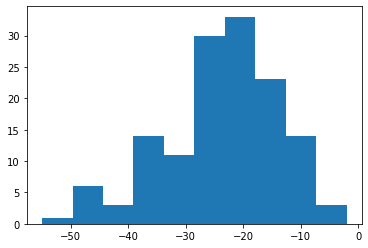

In [82]:
# update the time_diff
df['time_diff'] = (df['time_act']-df['time_sch']).dt.total_seconds() / 60
plt.hist(df.loc[df['time_sch'].dt.hour > df['time_act'].dt.hour,"time_diff"])

(array([26., 61., 54., 55., 31., 21., 20.,  8.,  5.,  4.]),
 array([ 5. , 14.3, 23.6, 32.9, 42.2, 51.5, 60.8, 70.1, 79.4, 88.7, 98. ]),
 <BarContainer object of 10 artists>)

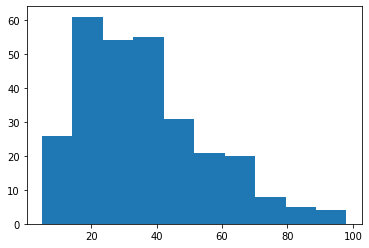

In [83]:
# compute the time delayed
df["delay"] = df["time_diff"] > 0
df["delay_time"] = df["time_diff"].apply(lambda time_diff: time_diff if time_diff >0 else pd.NA)
# plot delayed time below 100
delay_flights = df.loc[(df['time_sch'].dt.hour < df['time_act'].dt.hour) & (df['time_diff'] < 100)]
plt.hist(delay_flights["time_diff"])


In [85]:
delay_flights.describe()

,time_sch,time_act,time_diff
count,285,285,285.000000
mean,2024-04-23 14:20:31.578947328,2024-04-23 14:56:44,36.207018
min,2024-04-23 05:55:00,2024-04-23 06:09:00,5.000000
25%,2024-04-23 10:30:00,2024-04-23 11:03:00,21.000000
50%,2024-04-23 14:40:00,2024-04-23 15:08:00,33.000000
75%,2024-04-23 18:25:00,2024-04-23 19:04:00,48.000000
max,2024-04-23 22:15:00,2024-04-23 23:20:00,98.000000
std,NaN,NaN,19.233442


### Inspect the result dataframe

In [86]:
# return the first 5 rows
df.head()

,code,time_sch,orig,status,url,time_act,iata,dest,airline,dept,dest/orig,iata_airport,iata_city,terminal,time_diff,delay,delay_time
0,TP1363,2024-04-23 06:00:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,2024-04-23 06:21:00,Arrive Lisbon (LIS),Lisbon,TP,True,Lisbon,LIS,Lisbon,2,21.0,True,21.0
1,OS458,2024-04-23 06:00:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,2024-04-23 06:12:00,Arrive Vienna (VIE),Vienna,OS,True,Vienna,VIE,Vienna,2,12.0,True,12.0
2,LX345,2024-04-23 06:00:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-2...,2024-04-23 06:14:00,Arrive Zurich (ZRH),Zurich,LX,True,Zurich,ZRH,Zurich,2,14.0,True,14.0
3,BA472,2024-04-23 06:10:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-5...,2024-04-23 06:24:00,Arrive Barcelona (BCN),Barcelona,BA,True,Barcelona,BCN,Barcelona,5,14.0,True,14.0
4,AF1381,2024-04-23 06:15:00,London,DEPARTED,https://www.heathrow.com/departures/terminal-4...,2024-04-23 06:42:00,Arrive Paris (CDG),Paris,AF,True,Paris,CDG,Paris,4,27.0,True,27.0


In [92]:
# drop the redundant columns
df = df.drop(columns = ['time_diff','url'])
# export for temporary storage
df.to_csv("../data/23APR2024_LHR_processed.csv")

## Geospatial information
Since we have the IATA code of the destination/origin airport, we can return the location of the destination/origin with the following sources:
* https://raw.githubusercontent.com/ip2location/ip2location-iata-icao/master/iata-icao.csv

In [18]:
# load the raw file as csv
airport_df = pd.read_csv("https://raw.githubusercontent.com/ip2location/ip2location-iata-icao/master/iata-icao.csv")
# subset to only relevant airport
relevant = df["iata_airport"].unique()
airport_df = airport_df[airport_df['iata'].isin(relevant)]

# parse into gdf
# Convert DataFrame to GeoDataFrame
def create_point(row):
    return Point(row['longitude'], row['latitude'])

geometry = airport_df.apply(create_point, axis=1)
gdf = gpd.GeoDataFrame(airport_df, geometry=geometry)
# set the crs
gdf.crs = "EPSG:4326"
# inspect the dataframe
gdf.tail()

,country_code,region_name,iata,icao,airport,latitude,longitude,geometry
8522,US,Washington,SEA,KSEA,Seattle-Tacoma International Airport,47.4490,-122.3090,POINT (-122.30900 47.44900)
8635,UZ,-,TAS,UTTT,Tashkent International Airport,41.2579,69.2812,POINT (69.28120 41.25790)
8652,VC,Saint George,SVD,TVSA,Argyle International Airport,13.1443,-61.2109,POINT (-61.21090 13.14430)
8832,ZA,Gauteng,JNB,FAOR,O. R. Tambo International Airport,-26.1392,28.2460,POINT (28.24600 -26.13920)
8894,ZA,Western Cape,CPT,FACT,Cape Town International Airport,-33.9648,18.6017,POINT (18.60170 -33.96480)


In [20]:
gdf.shape

(169, 8)

#### Validation
Check that all the airport code in the flight data frame is also available in the `gdf`.

In [21]:
# find the missing airport
missing_airport = set(gdf['iata']).difference(df['iata_airport'])
missing_airport

set()

In [ ]:
# manual input
airport_code = ['BSL', 'GRU', 'LIN', 'PKX']
airport_names = ["EuroAirport Basel Mulhouse Freiburg","São Paulo–Guarulhos International Airport",
                "Milan Linate Airport","Beijing Daxing International Airport"]
country_code = ["FR","BR","IT","CN"]
gdf_new = gpd.GeoDataFrame(columns = ["country_code","iata","icao","airport","latitude","longitude","geometry"])
# manual append
for i, airport_name in enumerate(airport_names):
    # get the georaphical location
    try:
        geo_loc = ox.features.features_from_address(airport_name, tags = {"aeroway":"aerodrome"})
        new_data = geo_loc[["icao","geometry"]].reset_index(drop =True)
        new_data['latitude'] = new_data.geometry.centroid.y
        new_data['longitude'] = new_data.geometry.centroid.x
        new_data['country_code'] = country_code[i]
        new_data['iata'] = airport_code[i]
        new_data["airport"] = airport_name
        gdf_new = pd.concat([gdf_new,new_data],ignore_index= True)
    except:
        print(f"Error getting geographical informaiton for {airport_name}")

# manually add Sao Paolo Airort
latitude = -23.4258 
longitude = -46.4683
geomtry = Point(longitude,latitude)
data = ["BR","GRU","SBGR","São Paulo–Guarulhos International Airport",latitude,longitude,geometry]
gdf_new.loc[len(gdf_new)] = data

In [23]:
gdf = pd.concat([gdf,gdf_new]).reset_index(drop = True)
gdf.head()

,country_code,region_name,iata,icao,airport,latitude,longitude,geometry
0,AE,Abu Zaby,AUH,OMAA,Abu Dhabi International Airport,24.4330,54.6511,POINT (54.6511 24.433)
1,AE,Dubayy,DXB,OMDB,Dubai International Airport,25.2528,55.3644,POINT (55.3644 25.2528)
2,AG,Saint George,ANU,TAPA,V. C. Bird International Airport,17.1367,-61.7927,POINT (-61.7927 17.1367)
3,AR,Buenos Aires,EZE,SAEZ,Ministro Pistarini International Airport,-34.8222,-58.5358,POINT (-58.5358 -34.8222)
4,AT,Niederosterreich,VIE,LOWW,Vienna International Airport,48.1103,16.5697,POINT (16.5697 48.1103)


In [24]:
gdf.shape

(173, 8)

In [28]:
gdf.to_csv("../data/airport_location.csv")

### Country and Region

In [55]:
m49 = pd.read_csv("https://raw.githubusercontent.com/cwtravisyip/unsd_global_database/main/UNSD_m49.csv", delimiter=";")

### Validation
In this section, we will see if we can successfully merge the airport and country data onto the flights schedule data.

In [56]:
# find country in airport data that is not in m49
set(gdf['country_code']).difference(m49["ISO-alpha2 Code"])


{'TW'}

In [ ]:
# manually add m49 information
china = m49.query("`Country or Area` == 'China'")
china["ISO-alpha2 Code"] = "TW"
china["ISO-alpha3 Code"] = "TWN"
china["Country or Area"] = "Taiwan"
# add to the m49 table
m49 = pd.concat([m49,china],ignore_index = True)

In [58]:
m49.to_csv("../data/m49_processed.csv")

## Airline Information

In [59]:
# get the data
iata_airline = "https://raw.githubusercontent.com/elmoallistair/datasets/main/airlines.csv"
# return as pd df
iata_airline = pd.read_csv(iata_airline)
# inspect
iata_airline.head()

,Name,IATA,ICAO,Callsign,Country,Active
0,Private flight,-,NaN,NaN,NaN,Y
1,135 Airways,NaN,GNL,GENERAL,United States,N
2,1Time Airline,1T,RNX,NEXTIME,South Africa,Y
3,2 Sqn No 1 Elementary Flying Training School,NaN,WYT,NaN,United Kingdom,N
4,213 Flight Unit,NaN,TFU,NaN,Russia,N


In [73]:
# get the list of relevant airline
iata_airline_sub = iata_airline[iata_airline["IATA"].isin(set(df['airline']))]
# export 
iata_airline_sub.to_csv("../data/airlines.csv")

In [94]:
iata_airline[iata_airline["ICAO"] == "GEC"]

,Name,IATA,ICAO,Callsign,Country,Active
3317,Lufthansa Cargo,LH,GEC,LUFTHANSA CARGO,Germany,Y
